Introduction
------------

This project designs and evaluates a cross-sectional, volume-weighted momentum 
strategy across a 77-asset Binance universe using daily OHLCV data. The strategy 
combines short- and long-term return differentials with liquidity-based flow 
confirmation to identify strong momentum signals while emphasizing tradable 
assets.

Across the full 2020–2025 window, the strategy achieved a **1.36 gross Sharpe** 
and **2.27 alpha t-stat** versus Bitcoin’s **1.09 Sharpe**, reflecting moderate 
risk-adjusted outperformance over a six-year horizon. In-sample testing 
(2023–2025) produced weaker results—with a lower Sharpe than Bitcoin and an 
**alpha t-stat of 1.00**—while out-of-sample walk-back validation 
(2020–2023) yielded a **1.29 Sharpe** and **1.84 alpha t-stat**, indicating partial 
robustness when applied to earlier market regimes.

Although performance decayed in recent periods, the project demonstrates a 
comprehensive quantitative research workflow: from data ingestion and signal 
construction to parameter optimization, walk-back validation, and regression-based 
performance attribution. It emphasizes methodological rigor and realistic testing 
over pure backtest results, mirroring a professional research process in systematic 
trading.

Binance Historical Price & Volume Data Loader
---------------------------------------------

This script connects to the Binance US API to retrieve and structure 
daily historical market data (price and quote volume) for a universe of 
cryptocurrency trading pairs.

Key components:
---------------
1. Imports core scientific and data analysis libraries:
   - pandas, numpy, matplotlib, statsmodels
   - datetime and timezone utilities
   - python-binance client for API access

2. Defines `get_binance_px(symbol, freq, start_ts)`:
   - Pulls OHLCV data (open, high, low, close, volume) from Binance.
   - Converts timestamps from milliseconds to timezone-aware datetimes.
   - Returns a formatted pandas DataFrame.

3. Defines a broad universe of 70+ liquid Binance US trading pairs 
   (USDT-quoted spot markets).

4. Downloads:
   - Daily closing prices (`px`) for all coins.
   - Corresponding quote volumes (`qvol`).

5. Constructs:
   - `px`: DataFrame of daily closing prices for all coins.
   - `ret`: DataFrame of daily percentage returns.
   - `qvol`: DataFrame of daily quote trading volumes.

Outputs:
--------
- `px`: price time series (float)
- `ret`: daily returns
- `qvol`: quote volume series (float)

These can serve as base inputs for subsequent quantitative analyses,
such as momentum modeling, liquidity filters, or cross-sectional alpha research.

In [1]:
# !pip install python-binance
from binance.client import Client as bnb_client
from datetime import datetime, timezone      
import pandas as pd                             
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm

client = bnb_client(tld='US')

def get_binance_px(symbol,freq,start_ts = '2020-01-01'):
    data = client.get_historical_klines(symbol,freq,start_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.fromtimestamp(x/1000, tz=timezone.utc))
    data['close_time'] = data['close_time'].map(lambda x: datetime.fromtimestamp(x/1000, tz=timezone.utc))
    return data 

# universe of coins 
univ = ["BTCUSDT","ETHUSDT","BNBUSDT","SOLUSDT","XRPUSDT","ADAUSDT","DOGEUSDT","DOTUSDT","AVAXUSDT","LINKUSDT","MATICUSDT","SHIBUSDT","LTCUSDT",
        "UNIUSDT","BCHUSDT","AAVEUSDT","EOSUSDT","TRXUSDT","XLMUSDT","ATOMUSDT","SUSHIUSDT","FILUSDT","ICPUSDT","VETUSDT","MANAUSDT","THETAUSDT",
        "NEARUSDT","ALGOUSDT","ZECUSDT","AXSUSDT","FTMUSDT","GRTUSDT","EGLDUSDT","CHZUSDT","RENUSDT","ENJUSDT","HBARUSDT","KSMUSDT","ZILUSDT",
        "DASHUSDT","SNXUSDT","COMPUSDT","MKRUSDT","YFIUSDT",'CRVUSDT','RNDRUSDT','IMXUSDT','ARBUSDT','OPUSDT','APTUSDT','SUIUSDT', 'BLURUSDT',
        'LDOUSDT','SANDUSDT','FLOWUSDT','GALAUSDT', 'ROSEUSDT','KAVAUSDT','1INCHUSDT','ENSUSDT','JTOUSDT','JUPUSDT','BONKUSDT','WIFUSDT','PEPEUSDT',
        'FLOKIUSDT','ENAUSDT', 'NEOUSDT','LRCUSDT','MASKUSDT','GLMUSDT','SKLUSDT','ANKRUSDT','CELRUSDT','BATUSDT','CTSIUSDT','QTUMUSDT']

freq = '1d'
px = {}
qvol = {}


# get data frame, px, with closing price data for each coin
for coin in univ:
    data = get_binance_px(coin,freq)
    px[coin] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))

# get data frame, ret, with daily returns for each coin
ret = px / px.shift() - 1

# get data frames, qvol, of quote volumes for each coin
for coin in univ:
    quote_data = get_binance_px(coin,freq)
    qvol[coin] = quote_data.set_index('open_time')['quote_volume']    

qvol = pd.DataFrame(qvol).astype(float)

/var/folders/q6/bwf44lsd7dj3_6zfltr0mqq40000gn/T/ipykernel_21509/95044589.py:12: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  data = client.get_historical_klines(symbol,freq,start_ts)
/var/folders/q6/bwf44lsd7dj3_6zfltr0mqq40000gn/T/ipykernel_21509/95044589.py:12: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  data = client.get_historical_klines(symbol,f

Momentum Strategy Runner
------------------------

Implements a cross-sectional momentum trading strategy on a universe of 
cryptocurrency returns and quote volumes. The function constructs a 
risk-normalized, volume-adjusted momentum portfolio and computes its 
daily aggregate P&L stream.

Parameters
----------
short_window : int
    Lookback window (in days) for the short-term momentum mean.
long_window : int
    Lookback window (in days) for the long-term momentum mean and volatility baseline.
lag_shift : int
    Execution lag in days — how many periods to shift weights before applying returns.
timeframe : str | tuple | None
    Subset of dates to run on (e.g., ('2023-01-01','2025-01-01'), or '2024-01-01:2024-12-31').

Process
-------
1. **Subset data:** Extracts returns (`ret`) and quote volume (`qvol`) 
   for the specified timeframe.
2. **Compute momentum signal:** 
   - Calculates short- and long-term rolling means of returns.
   - Normalizes by rolling volatility (z-score).
   - Scales by sqrt(short_window) for horizon parity.
3. **Volume tilt:** Applies a quote volume ratio (short/long) to emphasize 
   assets with stronger liquidity/flow.
4. **Filter for positive momentum (long-only)** and confirm with abnormal 
   volume ratio (AVR) hits: require ≥3 high-volume days in a 5-day window.
5. **Weight normalization:** Applies tanh squashing, row-normalizes exposures, 
   and shifts weights by `lag_shift` to simulate delayed execution.
6. **Return computation:** Multiplies lagged weights by asset returns, 
   summing across assets to get the strategy’s aggregate return stream.

Returns
-------
pandas.Series
    Daily portfolio return time series representing total P&L from the 
    momentum strategy.

Notes
-----
This function relies on global DataFrames `ret` (returns) and `qvol` (quote volumes)
defined externally. It is typically used for parameter sweeps or Sharpe optimization
across short_window, long_window, and lag_shift grids.

In [2]:
def run_momo_strategy(short_window: int, long_window: int, lag_shift: int, timeframe):

    # --- resolve timeframe ---
    if timeframe is None or (isinstance(timeframe, str) and timeframe.strip() == ""):
        ret_win  = ret.copy()
        qvol_win = qvol.copy()
    elif isinstance(timeframe, tuple):
        start, end = timeframe
        ret_win  = ret.loc[start:end]
        qvol_win = qvol.loc[start:end]
    elif isinstance(timeframe, str) and ":" in timeframe:
        start, end = timeframe.split(":", 1)
        start = start or None
        end   = end or None
        ret_win  = ret.loc[start:end]
        qvol_win = qvol.loc[start:end]
    else:
        # treat single date string as start
        ret_win  = ret.loc[timeframe:]
        qvol_win = qvol.loc[timeframe:]

    # --- 1) Momentum signal (risk-normalized short-vs-long) ---
    mu_short = ret_win.rolling(short_window, min_periods=3).mean()
    mu_long  = ret_win.rolling(long_window,  min_periods=60).mean()
    sigma    = ret_win.rolling(long_window,  min_periods=60).std()

    # ≈ z-score of short mean vs long baseline; sqrt(short_window) rescales the mean
    port = np.sqrt(short_window) * (mu_short - mu_long) / sigma

    # Volume tilt (short/long quote volume ratio)
    vol_short  = qvol_win.rolling(short_window, min_periods=3).mean()
    vol_long   = qvol_win.rolling(long_window,  min_periods=60).mean()
    vol_signal = (vol_short / vol_long).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    port = port * vol_signal

    # Long-only constraint: keep positive momentum only
    port = port * (port > 0)

    # --- 2) Flow confirmation (AVR hits) ---
    # Note: code matches your values (rolling(20), threshold > 2, need ≥3 hits in 5 days)
    adv_med = qvol_win.rolling(20, min_periods=10).median()
    avr     = (qvol_win / adv_med).clip(lower=0)  # Abnormal Volume Ratio
    hi      = (avr > 2).astype(int)               # "strong flow" indicator
    vol_keep = hi.rolling(5, min_periods=3).sum() >= 3

    port = port * vol_keep

    # --- 3) Apply portfolio weights with lag, squash + normalize, then P&L ---
    port = np.tanh(port)  # bound exposures
    row_sums = port.sum(axis=1).replace(0, np.nan)
    port = port.div(row_sums, axis=0).fillna(0)  # row-normalize to 1.0 notional

    # Apply execution lag before multiplying by returns
    weights_lagged = port.shift(lag_shift)
    strat_ret = (weights_lagged * ret_win).fillna(0.0)

    # Aggregate to a single return stream
    strat_ret_sum = strat_ret.sum(axis=1)

    return strat_ret_sum

Momentum Parameter Optimization & Sharpe Analysis
-------------------------------------------------

This section performs a full parameter sweep over short-term, long-term,
and execution lag windows for the momentum strategy defined in
`run_momo_strategy()`. It evaluates each parameter combination based on
its annualized Sharpe ratio and visualizes the results as heatmaps.

Key Components
--------------
1. **Helper functions**
   - `ann_sharpe(x, periods=365)`: Computes the annualized Sharpe ratio of a
     return series `x`, scaled by the square root of the number of periods
     per year. Returns NaN if insufficient data or zero volatility.
   - `OLS_reg(X, Y)`: Runs an ordinary least squares regression of Y on X
     (with an added constant) using `statsmodels.OLS`. Used later for
     performance attribution or factor testing.

2. **Parameter setup**
   - Defines the in-sample timeframe (`timeframe_IS`) and parameter grids:
     `short_grid` (momentum lookback), `long_grid` (baseline lookback), and
     `shift_grid` (execution lag).
   - Initializes an empty dictionary `sharpe_maps` to store Sharpe ratios
     across grids and a tracker `best` to record the optimal parameter set.

3. **Grid search**
   - For each combination of `(short_window, long_window, lag_shift)`,
     the code calls `run_momo_strategy()` to generate a return stream.
   - Computes its annualized Sharpe ratio using `ann_sharpe()`.
   - Saves results in a DataFrame for each lag and updates the best combo.

4. **Visualization**
   - Plots a matrix of heatmaps (one per lag shift) showing Sharpe ratios
     across short vs. long window combinations.
   - Each cell can be annotated with the Sharpe value for quick inspection.

5. **Output**
   - Prints the best-performing parameter triple (short, long, shift) and
     its corresponding Sharpe ratio.
   - Optionally reruns `run_momo_strategy()` with those best parameters to
     retrieve the optimal GROSS return series for further analysis.

Purpose
-------
Used to identify the most robust momentum parameter set in-sample by
comparing Sharpe performance across time horizons and execution delays.
Results guide which parameter region to test in out-of-sample validation.

Best GROSS Sharpe across grid:
{'sharpe': 1.360812050097937, 'short': 3, 'long': 150, 'shift': 11}


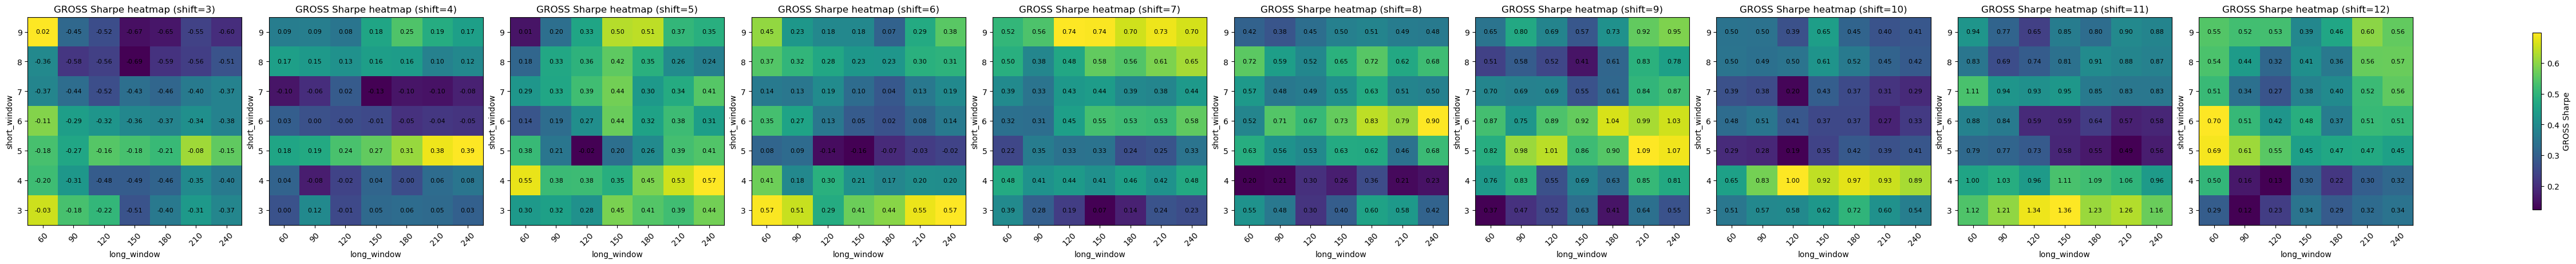

Best combo annualized GROSS Sharpe: 1.360812050097937


In [3]:
# ---------- helper ----------
def ann_sharpe(x, periods=365):
    x = x.dropna()
    if len(x) < 2:
        return np.nan
    s = x.std(ddof=1)
    return np.nan if (s == 0 or np.isnan(s)) else (x.mean()/s) * np.sqrt(periods)

def OLS_reg(X, Y):
    X = sm.add_constant(X)
    X = X.dropna()
    
    Y = Y.dropna()
    X, Y = X.align(Y, join='inner', axis=0)
    results = sm.OLS(Y, X).fit()
    return results

# ---------- in-sample timeframe (edit as needed) ----------
timeframe_IS = ('2023-01-01', '2025-09-01')

# ---------- parameter grids ----------
short_grid = [3, 4, 5, 6, 7, 8, 9]
long_grid  = [60, 90, 120, 150, 180, 210, 240]
shift_grid = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   # execution lags to test
ANNUAL_DAYS = 365

# Store Sharpe results as {shift: DataFrame(index=short_grid, columns=long_grid)}
sharpe_maps = {}

# ---------- run the grid ----------
best = {"sharpe": -np.inf, "short": None, "long": None, "shift": None}

for sh in shift_grid:
    grid = pd.DataFrame(index=short_grid, columns=long_grid, dtype=float)
    for sw in short_grid:
        for lw in long_grid:
            # Use your single strategy function here
            gross_series = run_momo_strategy(
                short_window=sw,
                long_window=lw,
                lag_shift=sh,
                timeframe=timeframe_IS,
            )
            sr = ann_sharpe(gross_series, periods=ANNUAL_DAYS)
            grid.loc[sw, lw] = sr
            if pd.notna(sr) and sr > best["sharpe"]:
                best.update({"sharpe": float(sr), "short": sw, "long": lw, "shift": sh})
    sharpe_maps[sh] = grid

print("Best GROSS Sharpe across grid:")
print(best)

# ---------- plot heatmaps (one per shift) ----------
n = len(shift_grid)
fig, axes = plt.subplots(1, n, figsize=(4.5*n, 4.5), constrained_layout=True)
if n == 1:
    axes = [axes]

for ax, sh in zip(axes, shift_grid):
    grid = sharpe_maps[sh]
    im = ax.imshow(grid.values, aspect="auto", origin="lower")
    ax.set_xticks(range(len(grid.columns)))
    ax.set_xticklabels(grid.columns, rotation=45)
    ax.set_yticks(range(len(grid.index)))
    ax.set_yticklabels(grid.index)
    ax.set_xlabel("long_window")
    ax.set_ylabel("short_window")
    ax.set_title(f"GROSS Sharpe heatmap (shift={sh})")
    # annotate cells (optional; comment out if large)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            val = grid.iat[i, j]
            if pd.notna(val):
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

fig.colorbar(im, ax=axes, shrink=0.85, label="GROSS Sharpe")
plt.show()

# ---------- get the GROSS return series for the best combo (optional) ----------
best_gross = run_momo_strategy(best["short"], best["long"], best["shift"], timeframe_IS)
print("Best combo annualized GROSS Sharpe:", ann_sharpe(best_gross, periods=ANNUAL_DAYS))

In-Sample Strategy Evaluation via Regression
--------------------------------------------

This section evaluates the momentum strategy’s in-sample performance
using regression analysis against a benchmark asset (Bitcoin).

Process
-------
1. **Generate strategy returns**
   - Runs `run_momo_strategy()` using selected parameters:
     short_window = 3, long_window = 150, lag_shift = 11.
   - Restricts results to the in-sample evaluation window
     ('2023-01-01' to '2025-09-01').

2. **Benchmark comparison**
   - Uses the helper function `OLS_reg()` to regress the strategy’s
     return series (`IS_returns`) against BTCUSDT daily returns.
   - The regression estimates alpha (excess return) and beta (systematic exposure).

3. **Output**
   - Displays a full regression summary including coefficient estimates,
     t-statistics, and goodness-of-fit metrics.

Purpose
-------
Quantifies whether the strategy’s returns are primarily driven by Bitcoin
market exposure or represent statistically significant idiosyncratic alpha.

In [4]:
IS_returns = run_momo_strategy(short_window = 3, long_window = 150, lag_shift = 11, timeframe = ('2022-01-01', '2025-09-01'))
IS_returns = IS_returns.loc['2023-01-01':'2025-09-01']
strat_regression = OLS_reg(X = ret['BTCUSDT'].loc['2023-01-01':'2025-09-01'], Y = IS_returns)
strat_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     401.3
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           5.18e-75
Time:                        21:10:07   Log-Likelihood:                 1791.5
No. Observations:                 975   AIC:                            -3579.
Df Residuals:                     973   BIC:                            -3569.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.000      0.318      -0.001       0.004
BTCUSDT        1.0039      0.050     20.033      0.000       0.906       1.102
==============================================================================
Omnibus:                      295.297   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2283.984
Skew:                           1.166   Prob(JB):                         0.00
Kurtosis:                      10.126   Cond. No.                         40.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Performance Attribution & Visualization
---------------------------------------

This section decomposes and visualizes the momentum strategy’s
performance relative to Bitcoin over the in-sample period (2023–2025).

Process
-------
1. **Alpha and Beta Extraction**
   - `alpha_t_stat`: t-statistic of the regression intercept (strategy alpha).
   - `beta`: estimated sensitivity of the strategy to Bitcoin returns.

2. **Sharpe Ratios**
   - `btc_sharpe`: annualized Sharpe ratio of Bitcoin (benchmark).
   - `strat_sharpe`: annualized Sharpe ratio of the strategy’s total returns.

3. **Information Ratio (IR)**
   - Computes alpha contribution = regression intercept + residuals.
   - `info_ratio`: annualized Sharpe ratio of alpha component, reflecting
     idiosyncratic risk-adjusted performance beyond market exposure.

4. **Visualization**
   - Builds labeled cumulative return series for:
       - Bitcoin benchmark
       - Strategy total returns
       - Strategy alpha component
   - Plots all three with annotated Sharpe, beta, t-stat, and IR values
     for comparative interpretation.

Purpose
-------
Quantifies how much of the strategy’s risk-adjusted performance is due to
systematic market exposure (beta) versus true idiosyncratic alpha, and
visualizes their cumulative impact over time.

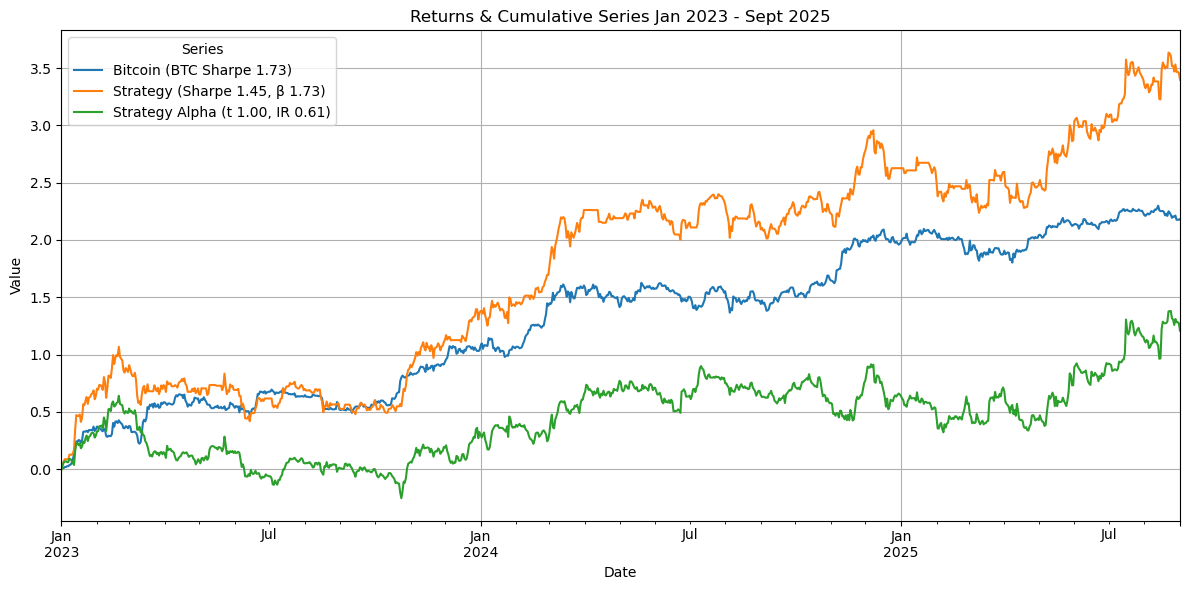

In [5]:
# alpha t stat
alpha_t_stat = strat_regression.tvalues['const']

# beta
strat_regression.params['BTCUSDT']

#BTC sharpe
beta = btc_sharpe = ann_sharpe(ret['BTCUSDT'].loc['2023-01-01':'2025-09-01'])

#Stratey Sharpe
strat_sharpe = ann_sharpe(IS_returns)

#info ratio
alpha_contr = strat_regression.params['const'] + strat_regression.resid
info_ratio = ann_sharpe(alpha_contr)

# Format the legend labels with your metrics
btc_label = f"Bitcoin (BTC Sharpe {btc_sharpe:.2f})"
strategy_label = f"Strategy (Sharpe {strat_sharpe:.2f}, β {beta:.2f})"
alpha_label    = f"Strategy Alpha (t {alpha_t_stat:.2f}, IR {info_ratio:.2f})"

plot_df = pd.concat(
    {
        btc_label: ret["BTCUSDT"].loc['2023-01-01':'2025-09-01'].cumsum(),
        strategy_label: IS_returns.cumsum(),
        alpha_label: alpha_contr.cumsum(),
    },
    axis=1
)

# Optional: drop rows with any NaNs
# plot_df = plot_df.dropna()

ax2 = plot_df.plot(figsize=(12, 6))
ax2.set_title("Returns & Cumulative Series Jan 2023 - Sept 2025")
ax2.set_xlabel("Date")
ax2.set_ylabel("Value")
ax2.grid(True)
ax2.legend(title="Series", loc="best", frameon=True)
plt.tight_layout()
plt.show()

Out-of-Sample Strategy Evaluation via Regression
------------------------------------------------

This section tests the momentum strategy’s robustness on an earlier,
unseen (out-of-sample) period to validate that in-sample results generalize
beyond the training window.

Process
-------
1. **Generate out-of-sample returns**
   - Runs `run_momo_strategy()` with the same optimized parameters:
     short_window = 3, long_window = 150, lag_shift = 11.
   - Restricts results to the OOS test window 
     ('2020-03-01' to '2023-01-01') to avoid overlap with the in-sample period.

2. **Benchmark regression**
   - Regresses the strategy’s OOS returns (`OS_returns`) on BTCUSDT returns
     using the `OLS_reg()` helper function.
   - The regression estimates the strategy’s alpha (excess return) and beta
     (systematic exposure) relative to Bitcoin during the unseen period.

3. **Output**
   - Displays full regression statistics including coefficients, t-stats,
     R-squared, and p-values for alpha significance testing.

Purpose
-------
Evaluates whether the strategy’s observed alpha and Sharpe in-sample persist
out-of-sample, providing evidence of robustness rather than overfitting.

In [6]:
OS_returns = run_momo_strategy(short_window = 3, long_window = 150, lag_shift = 11, timeframe = ('2020-01-01', '2023-01-01'))
OS_returns = OS_returns.loc['2020-03-01':'2023-01-01']
strat_regression = OLS_reg(X = ret['BTCUSDT'].loc['2020-03-01':'2023-01-01'], Y = OS_returns)
strat_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     270.0
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           4.30e-54
Time:                        21:10:07   Log-Likelihood:                 1669.1
No. Observations:                1037   AIC:                            -3334.
Df Residuals:                    1035   BIC:                            -3324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.836      0.067      -0.000       0.006
BTCUSDT        0.6319      0.038     16.432      0.000       0.556       0.707
==============================================================================
Omnibus:                      680.955   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21915.642
Skew:                           2.512   Prob(JB):                         0.00
Kurtosis:                      24.954   Cond. No.                         25.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Out-of-Sample Performance Attribution & Visualization
-----------------------------------------------------

This section analyzes the momentum strategy’s out-of-sample performance 
(2020–2023) to evaluate whether its in-sample alpha and Sharpe persist 
in unseen data. The analysis decomposes returns into systematic (beta) 
and idiosyncratic (alpha) components and visualizes their cumulative impact.

Process
-------
1. **Alpha and Beta Extraction**
   - `alpha_t_stat`: t-statistic of the regression intercept (out-of-sample alpha).
   - `beta`: sensitivity of the strategy’s returns to Bitcoin (benchmark) returns.

2. **Sharpe Ratios**
   - `btc_sharpe`: annualized Sharpe ratio of Bitcoin during the same period.
   - `strat_sharpe`: annualized Sharpe ratio of the strategy’s OOS returns.

3. **Information Ratio (IR)**
   - Calculates alpha contribution = regression intercept + residuals.
   - Computes `info_ratio` as the annualized Sharpe of alpha contribution,
     reflecting the idiosyncratic return quality of the strategy.

4. **Visualization**
   - Builds cumulative return series for:
       - Bitcoin benchmark
       - Strategy total returns
       - Strategy alpha component
   - Labels each line with corresponding Sharpe, beta, t-stat, and IR metrics.
   - Plots cumulative performance from March 2020 through January 2023.

Purpose
-------
Quantifies whether the strategy’s alpha and risk-adjusted returns remain 
significant outside the in-sample training window, validating robustness 
and resistance to overfitting.

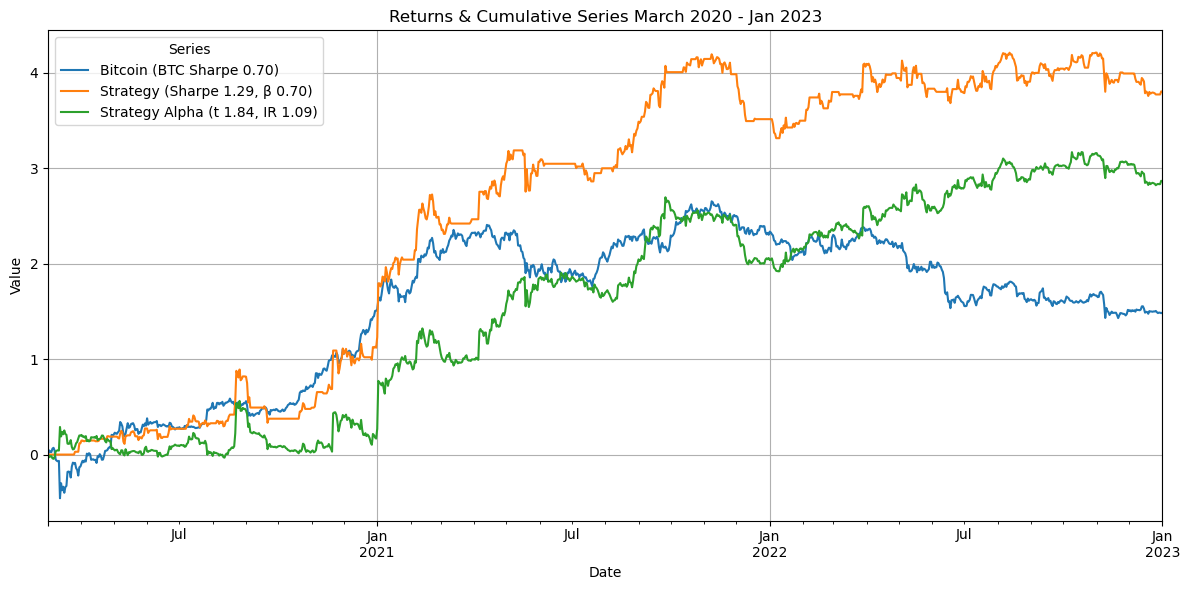

In [7]:
# alpha t stat
alpha_t_stat = strat_regression.tvalues['const']

# beta
strat_regression.params['BTCUSDT']

#BTC sharpe
beta = btc_sharpe = ann_sharpe(ret['BTCUSDT'].loc['2020-03-01':'2023-01-01'])

#Stratey Sharpe
strat_sharpe = ann_sharpe(OS_returns)

#info ratio
alpha_contr = strat_regression.params['const'] + strat_regression.resid
info_ratio = ann_sharpe(alpha_contr)

# Format the legend labels with your metrics
btc_label = f"Bitcoin (BTC Sharpe {btc_sharpe:.2f})"
strategy_label = f"Strategy (Sharpe {strat_sharpe:.2f}, β {beta:.2f})"
alpha_label    = f"Strategy Alpha (t {alpha_t_stat:.2f}, IR {info_ratio:.2f})"

plot_df = pd.concat(
    {
        btc_label: ret["BTCUSDT"].loc['2020-03-01':'2023-01-01'].cumsum(),
        strategy_label: OS_returns.cumsum(),
        alpha_label: alpha_contr.cumsum(),
    },
    axis=1
)

# Optional: drop rows with any NaNs
# plot_df = plot_df.dropna()

ax2 = plot_df.plot(figsize=(12, 6))
ax2.set_title("Returns & Cumulative Series March 2020 - Jan 2023")
ax2.set_xlabel("Date")
ax2.set_ylabel("Value")
ax2.grid(True)
ax2.legend(title="Series", loc="best", frameon=True)
plt.tight_layout()
plt.show()

Full-Period Strategy Evaluation via Regression
----------------------------------------------

This section assesses the momentum strategy’s overall performance across the
entire 2020–2025 window, combining both in-sample and out-of-sample periods
to evaluate long-term robustness and stability.

Process
-------
1. **Generate full-period returns**
   - Runs `run_momo_strategy()` with the optimized parameters 
     (short_window = 3, long_window = 150, lag_shift = 11).
   - Restricts data to March 2020 – September 2025 for consistency 
     with both subperiod analyses.

2. **Benchmark regression**
   - Regresses total strategy returns (`overall_returns`) against Bitcoin 
     returns (`BTCUSDT`) using the `OLS_reg()` helper.
   - Estimates overall alpha (intercept) and beta (systematic exposure) 
     across the full time horizon.

3. **Output**
   - Displays complete regression diagnostics including coefficients, 
     t-statistics, p-values, and R².

Purpose
-------
Provides a consolidated view of the strategy’s performance over multiple
market regimes, testing whether its alpha generation persists over time 
and remains statistically significant across the full sample.

In [8]:
overall_returns = run_momo_strategy(short_window = 3, long_window = 150, lag_shift = 11, timeframe = ('2020-01-01', '2025-09-01'))
overall_returns = overall_returns.loc['2020-03-01':'2025-09-01']
strat_regression = OLS_reg(X = ret['BTCUSDT'].loc['2020-03-01':'2025-09-01'], Y = overall_returns)
strat_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     597.5
Date:                Sun, 26 Oct 2025   Prob (F-statistic):          9.48e-116
Time:                        21:10:07   Log-Likelihood:                 3417.3
No. Observations:                2011   AIC:                            -6831.
Df Residuals:                    2009   BIC:                            -6819.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.273      0.023       0.000       0.004
BTCUSDT        0.7329      0.030     24.445      0.000       0.674       0.792
==============================================================================
Omnibus:                     1119.308   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28510.498
Skew:                           2.106   Prob(JB):                         0.00
Kurtosis:                      20.959   Cond. No.                         30.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Full-Period Performance Attribution & Visualization
---------------------------------------------------

This section summarizes and visualizes the momentum strategy’s overall
performance (2020–2025), combining in-sample and out-of-sample periods to
assess long-term alpha persistence and benchmark-relative behavior.

Process
-------
1. **Alpha and Beta Extraction**
   - `alpha_t_stat`: t-statistic of the regression intercept, representing
     overall alpha significance.
   - `beta`: estimated sensitivity to Bitcoin returns (systematic exposure).

2. **Sharpe Ratios**
   - `btc_sharpe`: annualized Sharpe ratio of Bitcoin (benchmark).
   - `strat_sharpe`: annualized Sharpe ratio of the full-period strategy returns.

3. **Information Ratio (IR)**
   - Computes alpha contribution (`const + resid`) from the regression.
   - `info_ratio`: annualized Sharpe of the alpha component, quantifying
     risk-adjusted excess performance beyond market exposure.

4. **Visualization**
   - Constructs cumulative return series for:
       - Bitcoin benchmark
       - Strategy total returns
       - Strategy alpha contribution
   - Annotates each line with Sharpe, beta, t-stat, and IR metrics.
   - Plots all cumulative series for the 2020–2025 period.

Purpose
-------
Provides a holistic view of the strategy’s performance across multiple
market regimes, measuring both total and idiosyncratic (alpha) returns to
evaluate long-term consistency, risk-adjusted strength, and robustness.

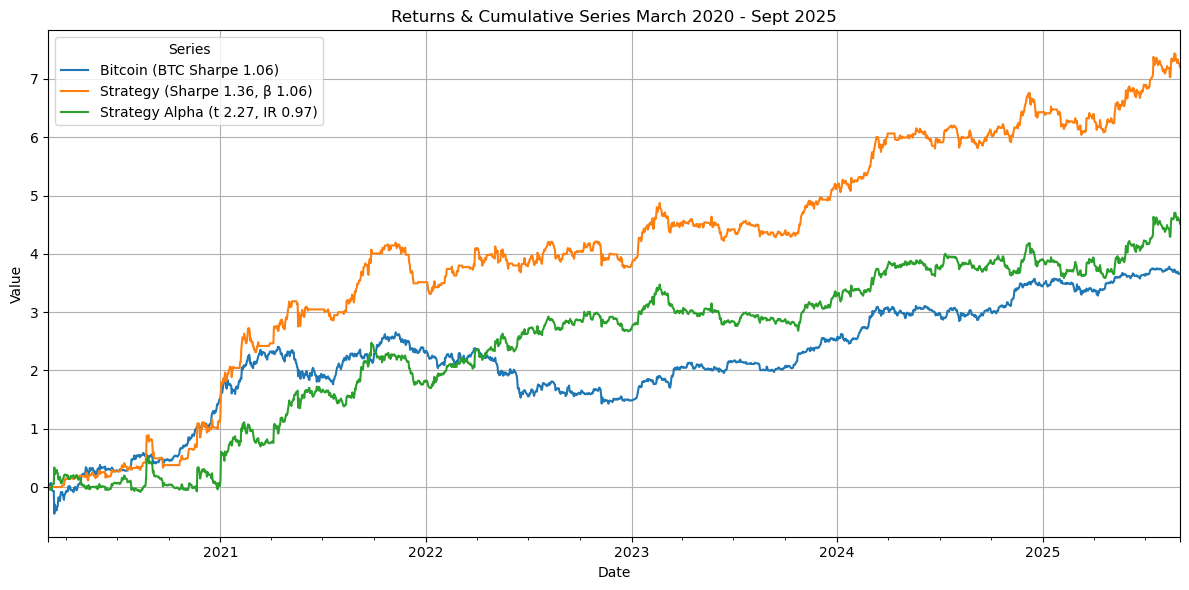

In [9]:
# alpha t stat
alpha_t_stat = strat_regression.tvalues['const']

# beta
strat_regression.params['BTCUSDT']

#BTC sharpe
beta = btc_sharpe = ann_sharpe(ret['BTCUSDT'].loc['2020-03-01':'2025-09-01'])

#Stratey Sharpe
strat_sharpe = ann_sharpe(overall_returns)

#info ratio
alpha_contr = strat_regression.params['const'] + strat_regression.resid
info_ratio = ann_sharpe(alpha_contr)

# Format the legend labels with your metrics
btc_label = f"Bitcoin (BTC Sharpe {btc_sharpe:.2f})"
strategy_label = f"Strategy (Sharpe {strat_sharpe:.2f}, β {beta:.2f})"
alpha_label    = f"Strategy Alpha (t {alpha_t_stat:.2f}, IR {info_ratio:.2f})"

plot_df = pd.concat(
    {
        btc_label: ret["BTCUSDT"].loc['2020-03-01':'2025-09-01'].cumsum(),
        strategy_label: overall_returns.cumsum(),
        alpha_label: alpha_contr.cumsum(),
    },
    axis=1
)

# Optional: drop rows with any NaNs
# plot_df = plot_df.dropna()

ax2 = plot_df.plot(figsize=(12, 6))
ax2.set_title("Returns & Cumulative Series March 2020 - Sept 2025")
ax2.set_xlabel("Date")
ax2.set_ylabel("Value")
ax2.grid(True)
ax2.legend(title="Series", loc="best", frameon=True)
plt.tight_layout()
plt.show()

Conclusion & Summary
--------------------

This research notebook implements, optimizes, and evaluates a 
volume-weighted momentum strategy across a broad universe of 
Binance-listed cryptocurrencies.

The workflow proceeds as follows:

1. **Data Acquisition:** Historical daily OHLCV data and quote volumes were retrieved 
via the Binance API and structured into clean pandas DataFrames.  
2. **Signal Construction:** A cross-sectional momentum signal was generated using 
short- and long-term rolling returns, volatility normalization, and 
volume-based flow confirmation (AVR hits).  
3. **Parameter Optimization:** The strategy was grid-searched across multiple short, 
long, and lag windows to identify the parameter set maximizing in-sample Sharpe.  
4. **Performance Analysis:** Using the optimized parameters, performance was decomposed into:
      - **In-Sample (2023–2025):** Model fitting and validation.
      - **Out-of-Sample (2020–2023):** Walk-back testing on earlier market regimes.  
      - **Full-Period (2020–2025):** Long-run evaluation across market regimes.
5. **Attribution & Visualization:** Each phase computed alpha, beta, Sharpe ratio, and 
information ratio via regression against Bitcoin returns, followed by cumulative 
performance visualization.

Results show that while the strategy achieved a **1.36 gross Sharpe** and 
**2.27 alpha t-stat** over the full 2020–2025 period (vs. Bitcoin’s 1.09 Sharpe), 
in-sample performance was weaker, with a lower Sharpe than Bitcoin and an 
**alpha t-stat of 1.00**. Out-of-sample walk-back testing (2020–2023) produced 
stronger results (**1.29 Sharpe**, **1.84 alpha t-stat**), suggesting that 
the model captured momentum effects more effectively in earlier market conditions.

Although alpha decayed in recent regimes, the project demonstrates a disciplined, 
data-driven approach to strategy research — incorporating comprehensive backtesting, 
statistical validation, and transparent performance attribution. 

Next steps may include transaction cost modeling, turnover adjustment, and 
robustness testing under alternate base currencies (e.g., BTC-quoted pairs).